In [2]:
import open3d as o3d
import numpy as np
from geomdl import BSpline
from geomdl.visualization import VisMPL
from geomdl import utilities
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from geomdl import exchange
import geomdl
from geomdl import fitting
from geomdl import BSpline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import alphashape
from shapely.geometry import Point, Polygon
from sklearn.decomposition import PCA
from descartes import PolygonPatch  # For plotting polygons
from shapely.prepared import prep



# import pyvista as pv



In [3]:
# Path to the point cloud file

# pointcloud_path = "/Users/noahbucher/Documents_local/Plant_reconstruction/ppheno/data/leaf_area/blue_leaf/pc_blueLeaf_03_s.ply"

pointcloud_path = "/Users/noahbucher/Documents_local/Plant_reconstruction/ppheno/data/leaf_area/musk_leaf/pc_muskLeaf_03_s.ply"

# pointcloud_path = "/Users/noahbucher/Documents_local/Plant_reconstruction/ppheno/data/leaf_area/white_leaf/pc_whiteLeaf_03_s.ply"


# Step 1: Load point cloud using Open3D
pcd = o3d.io.read_point_cloud(pointcloud_path)

In [4]:

points = np.asarray(pcd.points)


# Apply PCA to the point cloud
pca = PCA(n_components=3)
pca.fit(points)
points_pca = pca.transform(points)

# The principal axes
principal_axes = pca.components_

# Visualize the PCA-aligned point cloud
# pcd_pca = o3d.geometry.PointCloud()
# pcd_pca.points = o3d.utility.Vector3dVector(points_pca)
# o3d.visualization.draw_geometries([pcd_pca], window_name='PCA-Aligned Point Cloud')

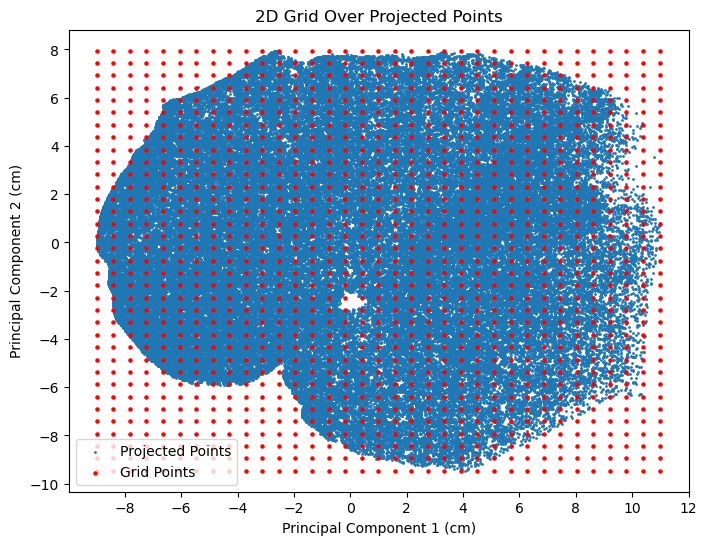

In [36]:
# Project the points onto the XY-plane
projected_points = points_pca[:, :2]

# Determine grid parameters
grid_size = 35  # Number of divisions along each axis
u_min, u_max = projected_points[:, 0].min(), projected_points[:, 0].max()
v_min, v_max = projected_points[:, 1].min(), projected_points[:, 1].max()
u_range = u_max - u_min
v_range = v_max - v_min

# Generate grid points
u_lin = np.linspace(u_min, u_max, grid_size)
v_lin = np.linspace(v_min, v_max, grid_size)
u_grid, v_grid = np.meshgrid(u_lin, v_lin)
grid_points_2d = np.column_stack((u_grid.flatten(), v_grid.flatten()))

# Visualize the grid over the projected points
plt.figure(figsize=(8, 6))
# plt.scatter(projected_points[:, 0], projected_points[:, 1], s=1, label='Projected Points')
# plt.scatter(grid_points_2d[:, 0], grid_points_2d[:, 1], c='red', s=5, label='Grid Points')

# in cm
plt.scatter(projected_points[:, 0]*100, projected_points[:, 1]*100, s=1, label='Projected Points')
plt.scatter(grid_points_2d[:, 0]*100, grid_points_2d[:, 1]*100, c='red', s=5, label='Grid Points')

# Set tick locations to have 2 cm intervals
plt.xticks(np.arange(-8, 12.5, 2))  
plt.yticks(np.arange(-10, 8.5, 2))  

plt.legend()
plt.title('2D Grid Over Projected Points')
plt.xlabel('Principal Component 1 (cm)')
plt.ylabel('Principal Component 2 (cm)')
plt.show()


In [6]:
from scipy.spatial import cKDTree

# Build a KD-tree for efficient neighbor search
tree = cKDTree(projected_points)

# Define the number of neighbors to average over (e.g., 10 closest points)
num_neighbors = 100

# Define a search radius (adjust as needed)
search_radius = max(u_range, v_range) / (grid_size * 2)

# Initialize list for control points
control_points = []

# Offset value along the third principal axis (e.g., -10 units)
offset_value = 1 * np.std(points_pca[:, 2])

for idx, (u_coord, v_coord) in enumerate(grid_points_2d):
    # Query the 10 closest points
    distances, indices = tree.query([u_coord, v_coord], k=num_neighbors)

    # Filter the points within the search radius
    within_radius = distances <= search_radius
    valid_indices = indices[within_radius]

    if len(valid_indices) > 0:
        # If there are points within the radius, take the average 3D coordinates of the closest ones
        nearby_points = points_pca[valid_indices]
        avg_point = np.mean(nearby_points, axis=0)
    else:
        # If no nearby points within the radius, keep the original grid point unchanged
        avg_point = np.array([u_coord, v_coord, offset_value])
    
    control_points.append(avg_point)

# Reshape control points into a grid
control_points = np.array(control_points)
control_points_grid = control_points.reshape((grid_size, grid_size, 3))


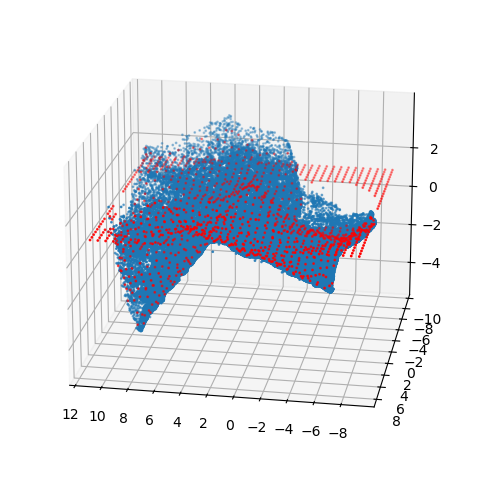

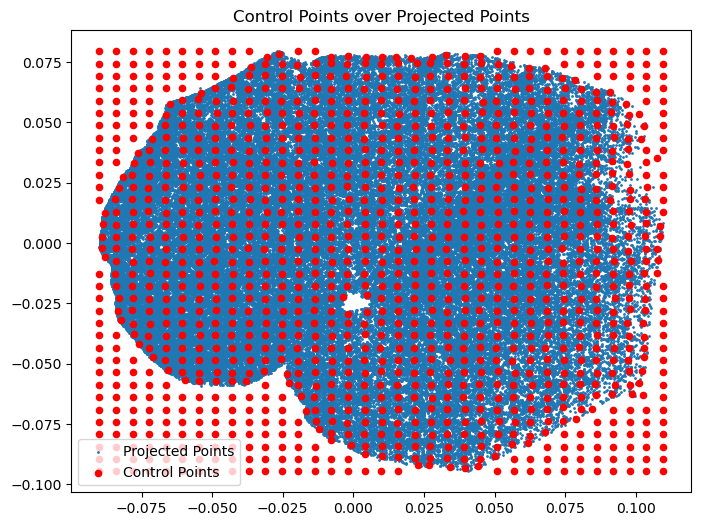

In [41]:
# Visualize control points in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the points and control points
# ax.scatter(points_pca[:, 0], points_pca[:, 1], points_pca[:, 2], s=1, label='Leaf Points')
# ax.scatter(control_points[:, 0], control_points[:, 1], control_points[:, 2], c='red', s=1, label='Control Points')

# adjust to cm
ax.scatter(points_pca[:, 0] * 100, points_pca[:, 1] * 100, points_pca[:, 2] * 100, s=1, label='Leaf Points')  # Convert to cm
ax.scatter(control_points[:, 0] * 100, control_points[:, 1] * 100, control_points[:, 2] * 100, c='red', s=1, label='Control Points')  # Convert to cm

# Set view angle: Elevation (elev) and Azimuth (azim)
ax.view_init(elev = 20, azim=100)  # Adjust these values as needed

# Set tick locations to have 2 cm intervals on each axis
ax.set_xticks(np.arange(-8, 12.5, 2))  # X-axis ticks from -8 cm to 12 cm, with a step of 2 cm
ax.set_yticks(np.arange(-10, 8.5, 2))  # Y-axis ticks from -10 cm to 8 cm, with a step of 2 cm
ax.set_zticks(np.arange(-4, 4, 2))  # Z-axis ticks from -5 cm to 5 cm, with a step of 2 cm

# Add legend and title
# ax.legend()
# ax.set_title('Control Points over Leaf Points (cm)')

# Show plot
plt.show()


# visualize points in 2D on prinicpal plane
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.scatter(projected_points[:, 0], projected_points[:, 1], s=1, label='Projected Points')
ax.scatter(control_points[:, 0], control_points[:, 1], c='red', s=20, label='Control Points')
ax.legend()
ax.set_title('Control Points over Projected Points')
plt.show()


In [24]:
from geomdl import BSpline, utilities
from geomdl.visualization import VisMPL

# Prepare control points for geomdl
# Flatten the grid into a single list of points
ctrlpts = []
for i in range(grid_size):
    for j in range(grid_size):
        point = control_points_grid[i, j, :]
        # Transform back to the original coordinate system
        point_orig = pca.inverse_transform(point)
        ctrlpts.append(point_orig.tolist())

# Create a B-Spline surface instance
surf = BSpline.Surface()

# Set degrees
surf.degree_u = 3
surf.degree_v = 3

# Set control points (flattened list)
surf.set_ctrlpts(ctrlpts, grid_size, grid_size)

# Generate a uniform knot vector
surf.knotvector_u = utilities.generate_knot_vector(surf.degree_u, surf.ctrlpts_size_u)
surf.knotvector_v = utilities.generate_knot_vector(surf.degree_v, surf.ctrlpts_size_v)


# Set evaluation delta (control the number of surface points)
surf.delta = 0.008

# Evaluate the surface
surf.evaluate()

# Visualize the surface
# vis_config = VisMPL.VisConfig(ctrlpts=True, legend=False)
# surf.vis = VisMPL.VisSurface(vis_config)
# surf.render()

exchange.export_obj(surf, "b_spline_surface.ply")



True

In [25]:
###### start with trimming the surface

In [26]:
# Convert to numpy array

# downsample the pointcloud with o3d
voxel_size = 0.002
downpcd = pcd.voxel_down_sample(voxel_size)



points = np.asarray(downpcd.points)
print(f"Loaded point cloud with {points.shape[0]} points.")


Loaded point cloud with 15719 points.


In [27]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
points_2d = pca.fit_transform(points)

print("Projected points onto a 2D plane using PCA.")

# # Visualize the 2D projection
# plt.figure(figsize=(8, 6))
# plt.scatter(points_2d[:, 0], points_2d[:, 1], s=1)
# plt.title('2D Projection of Point Cloud')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

Projected points onto a 2D plane using PCA.


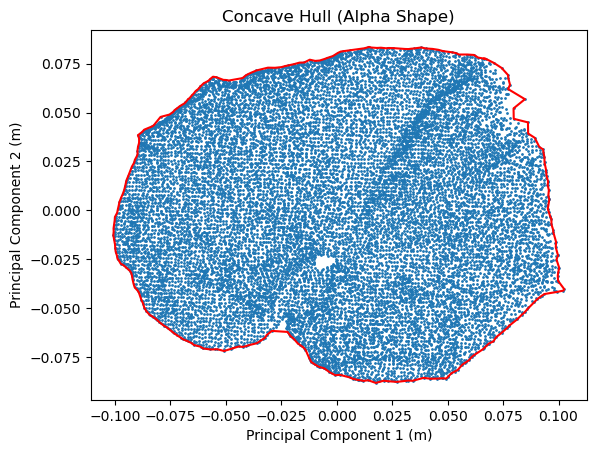

In [38]:
points_2d_cm = points_2d # Convert to cm
# Compute the alpha shape
alpha = 200  # Adjust alpha based on your data
concave_hull = alphashape.alphashape(points_2d_cm, alpha)

# Plot the alpha shape
fig, ax = plt.subplots()
ax.scatter(points_2d_cm[:, 0], points_2d_cm[:, 1], s=1)
ax.plot(*concave_hull.exterior.xy, color='red')
plt.title("Concave Hull (Alpha Shape)")
plt.xlabel("Principal Component 1 (m)")
plt.ylabel("Principal Component 2 (m)")
plt.show()


In [12]:
# Path to the B-spline mesh OBJ file
mesh_path = "b_spline_surface.obj"

# Load the mesh
mesh = o3d.io.read_triangle_mesh(mesh_path)

# Check if the mesh has vertex normals; if not, compute them
if not mesh.has_vertex_normals():
    mesh.compute_vertex_normals()

print("Loaded the B-spline mesh.")

Loaded the B-spline mesh.


In [13]:
# Get mesh vertices as a NumPy array
mesh_vertices = np.asarray(mesh.vertices)

# Project the mesh vertices using the same PCA transformer
mesh_vertices_2d = pca.transform(mesh_vertices)

print("Projected mesh vertices onto the 2D plane.")


Projected mesh vertices onto the 2D plane.


In [14]:
# Import necessary modules
from shapely.geometry import Point
from shapely.prepared import prep

# Prepare the concave hull for faster computations
concave_hull_prepared = prep(concave_hull)

# Determine which mesh vertices are inside the concave hull
inside_mask = np.array([concave_hull_prepared.contains(Point(x, y)) for x, y in mesh_vertices_2d])

print(f"Number of vertices inside the concave hull: {np.sum(inside_mask)}")

# Get the mesh triangles (faces) as a NumPy array
mesh_triangles = np.asarray(mesh.triangles)

# Identify faces where all three vertices are inside the concave hull
faces_inside_mask = inside_mask[mesh_triangles].all(axis=1)

# Select only the faces that are entirely inside the concave hull
trimmed_triangles = mesh_triangles[faces_inside_mask]

print(f"Number of triangles after trimming: {trimmed_triangles.shape[0]}")


Number of vertices inside the concave hull: 12957
Number of triangles after trimming: 25447


In [15]:
# Create the trimmed mesh
trimmed_mesh = o3d.geometry.TriangleMesh()
trimmed_mesh.vertices = mesh.vertices
trimmed_mesh.triangles = o3d.utility.Vector3iVector(trimmed_triangles)

# Remove unreferenced vertices to clean up the mesh
trimmed_mesh.remove_unreferenced_vertices()

# Optionally, recompute normals
trimmed_mesh.compute_vertex_normals()

print("Created the trimmed mesh.")


Created the trimmed mesh.


In [16]:
# Compute the surface area of the trimmed mesh
surface_area_m2 = trimmed_mesh.get_surface_area()
print(f"Surface area of the trimmed leaf: {surface_area_m2} square meters")

# Convert to square centimeters
surface_area_cm2 = surface_area_m2 * 10_000
print(f"Surface area of the trimmed leaf: {surface_area_cm2} square centimeters")


Surface area of the trimmed leaf: 0.032017627033351655 square meters
Surface area of the trimmed leaf: 320.1762703335165 square centimeters


In [17]:
# Export the trimmed mesh to a PLY or OBJ file
trimmed_mesh_path = "trimmed_leaf_mesh.ply"
o3d.io.write_triangle_mesh(trimmed_mesh_path, trimmed_mesh)
print(f"Trimmed mesh saved to: {trimmed_mesh_path}")


Trimmed mesh saved to: trimmed_leaf_mesh.ply
